# Index
- [Imports](#Imports)
- [CTEPG](#CTEPG-(Catching-The-Elusive-Predictable-Genes)-15-06-2020---22-06-2020)
- [Dyslipid database creation](#Creating-dyslipid-dataset)
- [Match / unmatch new results to old results (benign/pathogenic)](#AUC-validation-vanilla-new-model)
- [Cross validated models](#CV-Models)
- [XGB models out of CV models](#New-Models)
- [Correct new threshold](#Correct-probability-prediction)
- [AUC preparation & analysis](#Preparing-for-AUC-analysis)
- [Model on best performing panel, preparation](#Model-on-best-performing-panel,-prepartation)
- [AUC analysis new model on UMCG genepanels](#AUC-analysis-new-model-on-UMCG-genepanels)

# Imports

In [1]:
# Importing some shizzle.

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import time
import requests
import datetime
import sys
import os
import pathlib
import seaborn as sns
from sklearn.metrics import roc_auc_score
import math
import json
import glob
import gzip
import pickle
import xgboost as xgb
from utilities import perform_stats, calc_z_scores, get_header, genepanel_analysis
from sklearn.metrics import recall_score, roc_auc_score, precision_score, f1_score

# Defining some import and export locations
location = 'rjsietsma'
read_loc = '/run/media/rjsietsma/evo2tb/linux/Datafiles/'
data_expor_loc = '/home/'+location+'/Documents/School/Master_DSLS/Final_Thesis/Past_initial_data/'
img_output_dir = '/home/'+location+'/PycharmProjects/dsls_master_thesis/side_scripts/output_img/'

 # CTEPG (Catching The Elusive Predictable Genes) 15-06-2020 - 22-06-2020
<br/><br/>

What have I done:

- Made plot of Panel vs all combined:
![Panel vs all combined](img/allvs1boxplot_umcggenepanels.png)

- Issued [pull request](https://github.com/molgenis/capice/pull/1) for Dennis and Bart to be able to work with CAPICE locally.
- Refactored CAPICE code _(not finished)_.
- Retrained new models.
- Found new Pathogenic / Benign threshold within CAPICE.
- Made fancy new notebook with [indexing](#Index).



Planned for this week:
- Make barplot of type of variants for each panel.
- Feature importances for new base model vs feature importances specific model.
    - Scatter plot of base on the y axis and specific models on the x axis.
    - Do make multiple plots.
    - Make a feature importance rank delta (so how much do the feature importance ranks change?)
- Rebuild benchmarking dataset to the full dataset in Initial Data Exploration.
- Model refinement:
    - AUC analysis of new model (model xgb_booster37.pickle.dat)
    - Check for improvements.
    - Then split the training / testing data in the different models. (xgb_booster37.pickle.dat and xgb_booster_dyslipid.pickle.dat)
        - Also do the full dataset on dyslipid. Do not try to split the data into the 2 models. 
        - Try to build new models on average performing and well performing panels aswell, try to see if everything improves nicely.
            - Could conclude from this: performance improves a lot for bad performing panels when trained on those bad performing panels, not so much for good performing panels (but do improve). If trained on good performing models, does that do the same?
    - AUC analysis again.
    - Upgrade to CADD 1.6, train again.
    - AUC analysis.
    - [Convert to genome build 38](https://genome.ucsc.edu/cgi-bin/hgLiftOver)
    - Make [pseudo-VCF](http://samtools.github.io/hts-specs/VCFv4.1.pdf) of build 38 train file and test file.
    - Repeat.
    - Then choose between:
        - Newer / larger datasets or
        - Adding features specific to the benefits of the different models (prefered)
        - _Note: Shuang her data has almost half the variants than the newer VGKL and Clinvar datasets, with 3913 benign and 1116 malignant samples._
- Start investigating what is required for the data sources to be used in the training phase.
- Create outline for article.
     - For static plots: make labels on each point with the term name and the number of genes in (n=x) behind that.
     - For first concept, it's due date is the last week of the resit exams on the 6th of July.
- _Optionally_ :
    - Find possible way to annotate genes for co-factors, sub-family etc.
    - Interactive plot of all variants labeled as benign or pathogenic with their capice score (y-axis) and location (x-axis), to show the variant itself.
<br/><br/>

# Creating dyslipid dataset

In [2]:
file_loc = os.path.join(read_loc, 'train.txt.gz')
header = get_header(file_loc, '#Chrom')
train = pd.read_csv(file_loc, compression='gzip', names=header, comment='#', sep='\t', low_memory=False)
train

,#Chrom,Allergy/Immunology/Infectious,Alt,AnnoType,Audiologic/Otolaryngologic,Biochemical,CCDS,CDSpos,Cardiovascular,ConsDetail,...,revel,sift,source,tOverlapMotifs,targetScan,to_be_deleted,verPhCons,verPhyloP,inTest,sample_weight
0,14,False,G,CodingTranscript,False,False,CCDS9787.1,806.0,False,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,1.000,5.843,False,1.0
1,20,False,T,CodingTranscript,True,False,CCDS13112.1,1899.0,True,"frameshift,stop_gained",...,NaN,NaN,vkgl,NaN,NaN,False,1.000,4.670,False,1.0
2,20,False,C,CodingTranscript,True,False,CCDS13112.1,2118.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,1.000,5.043,False,1.0
3,20,False,A,CodingTranscript,True,False,CCDS13112.1,1586.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,1.000,6.221,False,1.0
4,20,False,A,Intergenic,True,False,NaN,NaN,True,downstream,...,NaN,NaN,vkgl,NaN,NaN,False,1.000,6.368,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334596,17,False,A,CodingTranscript,False,False,CCDS32642.1,1563.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,1.000,6.031,False,0.8
334597,17,False,T,CodingTranscript,False,False,CCDS32642.1,2029.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,1.000,4.100,False,0.8
334598,10,False,T,CodingTranscript,False,False,CCDS7431.1,1216.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,1.000,5.852,False,0.8
334599,2,False,T,CodingTranscript,False,False,CCDS2382.1,2998.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,0.031,2.213,False,0.8


In [3]:
with open('./umcg_genepanels.json', 'r') as json_file:
    genes = json.load(json_file)
dislipid_genes = genes['Hart- en vaatziekten']
genelist = []
for key, value in dislipid_genes.items():
    if key.lower().startswith('dyslipid'):
        for g in value:
            if g not in genelist:
                genelist.append(g)

In [4]:
dislipid_subset = train.loc[train['GeneName'].isin(genelist)]
dislipid_subset

,#Chrom,Allergy/Immunology/Infectious,Alt,AnnoType,Audiologic/Otolaryngologic,Biochemical,CCDS,CDSpos,Cardiovascular,ConsDetail,...,revel,sift,source,tOverlapMotifs,targetScan,to_be_deleted,verPhCons,verPhyloP,inTest,sample_weight
142,16,False,T,CodingTranscript,False,False,CCDS10772.1,848.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,0.928,2.614,False,1.0
148,19,False,CCGGCGAGGTGCAGGCCATGCT,CodingTranscript,False,False,CCDS12647.1,409.0,True,protein_altering,...,NaN,NaN,vkgl,NaN,NaN,True,0.863,0.839,False,1.0
149,2,False,C,CodingTranscript,False,False,CCDS1703.1,13028.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,0.000,0.058,False,1.0
150,2,False,G,CodingTranscript,False,False,CCDS1703.1,28.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,0.021,-0.103,False,1.0
151,2,False,C,CodingTranscript,False,False,CCDS1703.1,2534.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,0.653,0.251,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334284,12,False,T,CodingTranscript,False,False,CCDS8685.1,1093.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,0.999,3.072,False,0.8
334285,12,False,A,CodingTranscript,False,False,CCDS8685.1,1475.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,0.580,0.563,False,0.8
334286,12,False,T,CodingTranscript,False,False,CCDS8685.1,1537.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,0.003,0.643,False,0.8
334287,12,False,G,CodingTranscript,False,False,CCDS8685.1,1553.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,0.510,2.765,False,0.8


In [5]:
dislipid_subset['label'].value_counts()

Benign        3913
Pathogenic    1116
Name: label, dtype: int64

# CV Models

In [6]:
model = pickle.load(open('./models/xgb_weightedSample_randomsearch_v2.pickle.dat', 'rb'))
xgbmodel = model.best_estimator_
optimal_params = xgbmodel.get_params()
optimal_params.pop('missing')
with open('./optimal_capice_v2_params.json', 'w+') as json_file:
    json.dump(optimal_params, json_file, indent=4)
optimal_params

{'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.12794736796290956,
 'max_delta_step': 0,
 'max_depth': 15,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_estimators': 420,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': 1}

In [7]:
model = xgb.XGBClassifier(optimal_params)

In [8]:
model_dislipid = pickle.load(open('./models/xgb_weightedSample_randomsearch_dislipid.pickle.dat', 'rb'))
xgbmodel_dislipid = model_dislipid.best_estimator_
optimal_params_dislipid = xgbmodel_dislipid.get_params()
optimal_params_dislipid.pop('missing')
with open('./optimal_capice_dislipid_params.json', 'w+') as json_file:
    json.dump(optimal_params_dislipid, json_file, indent=4)
optimal_params_dislipid

{'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.1968770013672272,
 'max_delta_step': 0,
 'max_depth': 16,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_estimators': 427,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': 1}

# New Models

In [9]:
model = pickle.load(open('./xgbmodels/xgb_booster_v2.pickle.dat', 'rb'))
model.feature_importances_

array([0.00282909, 0.00207738, 0.00183909, 0.00320904, 0.00281486,
       0.00190347, 0.00192447, 0.00191927, 0.00175739, 0.00351866,
       0.00253019, 0.00301028, 0.00308079, 0.00301589, 0.00242207,
       0.00284953, 0.00254809, 0.00301885, 0.00276217, 0.00329895,
       0.0029472 , 0.00288387, 0.00196225, 0.00324255, 0.00249287,
       0.00308638, 0.00275804, 0.00326703, 0.003321  , 0.02822421,
       0.01098935, 0.00849544, 0.0026135 , 0.0021958 , 0.00212344,
       0.02957111, 0.00307086, 0.00227875, 0.00224516, 0.00332749,
       0.00291972, 0.00251198, 0.00405553, 0.00422445, 0.00319547,
       0.00250752, 0.00358728, 0.0023705 , 0.00314594, 0.00369558,
       0.00300821, 0.00350186, 0.00383268, 0.00286349, 0.00239821,
       0.00318689, 0.00370395, 0.00359068, 0.00305595, 0.01804393,
       0.00381216, 0.00197791, 0.0018304 , 0.0023901 , 0.00244684,
       0.00294106, 0.00317492, 0.00303257, 0.00199907, 0.00196537,
       0.00232091, 0.00312337, 0.00172605, 0.00178056, 0.     

In [10]:
model_dislipid = pickle.load(open('./xgbmodels/xgb_booster_dyslipid.pickle.dat', 'rb'))
model_dislipid.feature_importances_

array([0.00278866, 0.00208772, 0.00174322, 0.00296931, 0.00269667,
       0.00179555, 0.00186813, 0.00186437, 0.00175499, 0.00395201,
       0.00240749, 0.00280701, 0.00290935, 0.00285559, 0.0023123 ,
       0.0027687 , 0.0024073 , 0.00306501, 0.00286279, 0.00350749,
       0.00261141, 0.00282689, 0.00188535, 0.00320358, 0.00238541,
       0.00293148, 0.00261692, 0.00331071, 0.00368271, 0.02656523,
       0.01037843, 0.00846208, 0.00255091, 0.00212624, 0.00206606,
       0.03021989, 0.0027948 , 0.00225078, 0.00219586, 0.00343691,
       0.00298393, 0.00254942, 0.00387159, 0.00394147, 0.00327632,
       0.00257063, 0.00359947, 0.00250112, 0.00339626, 0.00355939,
       0.0030033 , 0.00344496, 0.00338445, 0.00294264, 0.00213853,
       0.00313247, 0.00377457, 0.00349594, 0.00298174, 0.01875002,
       0.00379864, 0.00185824, 0.00179364, 0.00239529, 0.00231335,
       0.00317147, 0.00292523, 0.00316273, 0.00262851, 0.00228997,
       0.00601442, 0.00521736, 0.00169761, 0.00183883, 0.     

# AUC validation vanilla new model

In [11]:
train_original = pd.read_csv('/home/rjsietsma/Documents/School/Master_DSLS/Final_Thesis/Initial_Data_exploration/train_results.txt', sep='\t', low_memory=False)
train_original

,chr,pos,ref,alt,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction
0,17,41246652,ACATTC,GA,BRCA1,FRAME_SHIFT,26.600,9.999933e-01,Pathogenic,Pathogenic
1,19,11216246,TGCAAGGACAAATCTGAC,CCGACTG,LDLR,FRAME_SHIFT,35.000,9.999907e-01,Pathogenic,Pathogenic
2,19,11216251,GGACAAATCTGACGA,AACTGCGGTAAACTGCGGTAAACT,LDLR,FRAME_SHIFT,34.000,9.999896e-01,Pathogenic,Pathogenic
3,19,11216262,ACG,CA,LDLR,FRAME_SHIFT,34.000,9.999894e-01,Pathogenic,Pathogenic
4,2,47702328,GTTGA,TTTC,MSH2,FRAME_SHIFT,35.000,9.999891e-01,Pathogenic,Pathogenic
...,...,...,...,...,...,...,...,...,...,...
334596,14,64653189,T,C,MIR548AZ,SYNONYMOUS,14.370,2.765540e-07,Neutral,Neutral
334597,17,10419945,A,G,MYHAS,SYNONYMOUS,0.611,2.524258e-07,Neutral,Neutral
334598,17,10419849,T,G,MYHAS,SYNONYMOUS,9.827,2.164549e-07,Neutral,Neutral
334599,16,88804658,G,A,LOC100289580,SYNONYMOUS,14.100,1.984229e-07,Neutral,Neutral


In [12]:
train_new = pd.read_csv('./datafiles/train_results_v4.txt.gz', compression='gzip',
                       sep='\t', low_memory=False)
important_info = train_new['chr_pos_ref_alt'].str.split("_", expand=True)
train_new['chr'] = important_info[0]
train_new['pos'] = important_info[1].astype(np.int64)
train_new['ref'] = important_info[2]
train_new['alt'] = important_info[3]
train_new.drop(columns=['chr_pos_ref_alt'], inplace=True)
train_new

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt
0,LDLR,FRAME_SHIFT,35.000,9.999982e-01,Pathogenic,Pathogenic,19,11216252,GACAAA,TTT
1,BRCA2,FRAME_SHIFT,35.000,9.999978e-01,Pathogenic,Pathogenic,13,32936775,GAATTT,AG
2,LDLR,FRAME_SHIFT,35.000,9.999976e-01,Pathogenic,Pathogenic,19,11216246,TGCAAGGACAAATCTGAC,CCGACTG
3,LDLR,FRAME_SHIFT,34.000,9.999967e-01,Pathogenic,Pathogenic,19,11216262,ACG,CA
4,BRCA2,FRAME_SHIFT,20.800,9.999956e-01,Pathogenic,Pathogenic,13,32906847,TACCCCTATTG,ACAT
...,...,...,...,...,...,...,...,...,...,...
334596,MYHAS,SYNONYMOUS,10.130,7.769997e-08,Neutral,Neutral,17,10429043,G,A
334597,MYHAS,SYNONYMOUS,15.280,7.578360e-08,Neutral,Neutral,17,10415744,A,G
334598,MIR1273H,SYNONYMOUS,13.040,6.680243e-08,Neutral,Neutral,4,39448569,G,A
334599,MYHAS,SYNONYMOUS,12.770,5.909591e-08,Neutral,Neutral,17,10318882,G,A


In [13]:
merge = train_original[['chr', 'pos','ref','alt','prediction']].merge(train_new[['chr', 'pos','ref','alt','prediction']],
                                                                     on=['chr', 'pos','ref','alt'])
merge[merge['prediction_x'] != merge['prediction_y']]
print(f"There is a "
      f"{merge[merge['prediction_x'] != merge['prediction_y']].shape[0] / train_original.shape[0] * 100}% mismatch.")

There is a 4.3523480204781215% mismatch.


In [14]:
test_original = pd.read_csv('/home/rjsietsma/Documents/School/Master_DSLS/Final_Thesis/Initial_Data_exploration/test_results.txt', sep='\t', low_memory=False)
tellPathogenic_pred = lambda x: "Pathogenic" if x > 0.02 else 'Neutral'
test_original['prediction'] = [tellPathogenic_pred(probability) for probability in test_original['capice']]
test_original.rename(columns={'#Chrom': 'chr', 'Pos':'pos', 'Ref': 'ref', 'Alt':'alt'}, inplace=True)
test_original

,chr,pos,ref,alt,max_AF,Consequence,label,revel,clinpred,sift,provean,PHRED,fathmm_score,capice,ponp2,prediction
0,21,33974174,C,G,0.000058,STOP_LOST,LB/B,NaN,NaN,NaN,NaN,15.050,NaN,0.003275,NaN,Neutral
1,X,99661625,G,C,0.000037,SYNONYMOUS,LB/B,NaN,NaN,0.000,-0.0,0.806,NaN,0.000075,NaN,Neutral
2,17,29509638,C,T,0.000000,SYNONYMOUS,LB/B,NaN,NaN,0.647,-0.0,10.760,NaN,0.001511,NaN,Neutral
3,21,35742999,C,T,0.000133,SYNONYMOUS,LB/B,NaN,NaN,0.000,-0.0,18.640,NaN,0.000621,NaN,Neutral
4,1,2160973,G,A,0.000000,SYNONYMOUS,LB/B,NaN,NaN,0.000,-0.0,16.340,0.008252,0.000012,NaN,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10837,17,29556342,G,A,0.000000,SYNONYMOUS,LP/P,NaN,NaN,0.000,-0.0,11.450,NaN,0.000139,NaN,Neutral
10838,11,5248177,A,T,0.000344,SYNONYMOUS,LP/P,NaN,NaN,0.000,-0.0,17.970,NaN,0.069934,NaN,Pathogenic
10839,15,48787324,T,C,0.000000,SYNONYMOUS,LP/P,NaN,NaN,0.664,-0.0,12.170,0.019530,0.909190,NaN,Pathogenic
10840,19,17947957,G,A,0.000015,SYNONYMOUS,LP/P,NaN,NaN,0.000,-0.0,10.990,NaN,0.001238,NaN,Neutral


In [15]:
test_new = pd.read_csv('./datafiles/test_results_v4.txt.gz', compression='gzip',
                       sep='\t', low_memory=False)
important_info = test_new['chr_pos_ref_alt'].str.split("_", expand=True)
test_new['chr'] = important_info[0]
test_new['pos'] = important_info[1].astype(np.int64)
test_new['ref'] = important_info[2]
test_new['alt'] = important_info[3]
test_new.drop(columns=['chr_pos_ref_alt'], inplace=True)
test_new

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt
0,BRCA1,STOP_GAINED,34.000,9.999962e-01,Pathogenic,Pathogenic,17,41243705,CTGAG,GCCT
1,BRCA2,FRAME_SHIFT,26.900,9.999943e-01,Pathogenic,Pathogenic,13,32912883,CTG,TT
2,MSH2,FRAME_SHIFT,34.000,9.999934e-01,Pathogenic,Pathogenic,2,47639582,AGAAA,TAAT
3,BRCA2,FRAME_SHIFT,24.100,9.999933e-01,Pathogenic,Pathogenic,13,32912590,TA,T
4,BRCA2,FRAME_SHIFT,25.600,9.999924e-01,Pathogenic,Pathogenic,13,32913442,TC,T
...,...,...,...,...,...,...,...,...,...,...
10837,MIR548AZ,NON_SYNONYMOUS,5.553,1.214339e-06,Neutral,Neutral,14,64537567,G,C
10838,MYHAS,INTRONIC,0.068,8.699849e-07,Neutral,Neutral,17,10432854,G,A
10839,NBPF20,REGULATORY,3.320,6.732982e-07,Neutral,Neutral,1,145439717,C,G
10840,MYHAS,DOWNSTREAM,0.035,6.130708e-07,Neutral,Neutral,17,10442488,G,A


In [16]:
merge = test_original[['chr', 'pos','ref','alt','prediction']].merge(test_new[['chr', 'pos','ref','alt','prediction']],
                                                                     on=['chr', 'pos','ref','alt'])
merge[merge['prediction_x'] != merge['prediction_y']]
print(f"There is a "
      f"{merge[merge['prediction_x'] != merge['prediction_y']].shape[0] / test_original.shape[0] * 100}% mismatch.")

There is a 14.25936174137613% mismatch.


# Correct probability prediction

### Currently marked as markdown to prevent executing again when re-launching the notebook

thresholds = np.arange(0,1,0.001)
data = pd.read_csv('/home/rjsietsma/PycharmProjects/dsls_master_thesis/side_scripts/test_output/train_results_v3.txt',
                  sep='\t', low_memory=False)
important_info = data['chr_pos_ref_alt'].str.split("_", expand=True)
data['chr'] = important_info[0]
data['pos'] = important_info[1].astype(np.int64)
data['ref'] = important_info[2]
data['alt'] = important_info[3]
data.drop(columns=['chr_pos_ref_alt'], inplace=True)
data

train_in = pd.read_csv('/run/media/rjsietsma/evo2tb/linux/Datafiles/train.txt.gz',
                      compression='gzip', sep='\t', low_memory=False)
train_in

data = data.merge(train_in[['#Chrom', 'Pos', 'Ref', 'Alt', 'label']],
                           left_on=['chr','pos','ref','alt'],
                           right_on=['#Chrom','Pos','Ref','Alt'])
data

drop_labels = ['#Chrom', 'Pos', 'Ref', 'Alt']
for x in data.columns:
    if x.endswith('_x') or x.endswith('_y'):
        drop_labels.append(x)
data.drop(columns=drop_labels, inplace=True)

def apply_func_thresholding(probability, threshold):
    return_value = 0
    if probability > threshold:
        return_value = 1
    return return_value

data['label'].replace({'Pathogenic': 1, 'Benign': 0}, inplace=True)

true_recall = 0
true_threshold = 0
for threshold in thresholds:
    data['pred_label'] = data['probabilities'].apply(lambda x: apply_func_thresholding(x, threshold))
    y_pred = np.array(data['pred_label'])
    y_true = np.array(data['label'])
    recall = recall_score(y_pred, y_true, zero_division=0)
    if 0.94 <= recall <= 0.96:
        true_recall = recall
        true_threshold = threshold
        break
print(f'Recall {true_recall} is found at threshold {true_threshold}.')

# Preparing for AUC analysis


In [17]:
train_out = train_new.copy()
train_out

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt
0,LDLR,FRAME_SHIFT,35.000,9.999982e-01,Pathogenic,Pathogenic,19,11216252,GACAAA,TTT
1,BRCA2,FRAME_SHIFT,35.000,9.999978e-01,Pathogenic,Pathogenic,13,32936775,GAATTT,AG
2,LDLR,FRAME_SHIFT,35.000,9.999976e-01,Pathogenic,Pathogenic,19,11216246,TGCAAGGACAAATCTGAC,CCGACTG
3,LDLR,FRAME_SHIFT,34.000,9.999967e-01,Pathogenic,Pathogenic,19,11216262,ACG,CA
4,BRCA2,FRAME_SHIFT,20.800,9.999956e-01,Pathogenic,Pathogenic,13,32906847,TACCCCTATTG,ACAT
...,...,...,...,...,...,...,...,...,...,...
334596,MYHAS,SYNONYMOUS,10.130,7.769997e-08,Neutral,Neutral,17,10429043,G,A
334597,MYHAS,SYNONYMOUS,15.280,7.578360e-08,Neutral,Neutral,17,10415744,A,G
334598,MIR1273H,SYNONYMOUS,13.040,6.680243e-08,Neutral,Neutral,4,39448569,G,A
334599,MYHAS,SYNONYMOUS,12.770,5.909591e-08,Neutral,Neutral,17,10318882,G,A


In [18]:
train_in = pd.read_csv('./datafiles/train.txt.gz',
                      compression='gzip', sep='\t', low_memory=False)
train_in

,#Chrom,Allergy/Immunology/Infectious,Alt,AnnoType,Audiologic/Otolaryngologic,Biochemical,CCDS,CDSpos,Cardiovascular,ConsDetail,...,revel,sift,source,tOverlapMotifs,targetScan,to_be_deleted,verPhCons,verPhyloP,inTest,sample_weight
0,14,False,G,CodingTranscript,False,False,CCDS9787.1,806.0,False,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,1.000,5.843,False,1.0
1,20,False,T,CodingTranscript,True,False,CCDS13112.1,1899.0,True,"frameshift,stop_gained",...,NaN,NaN,vkgl,NaN,NaN,False,1.000,4.670,False,1.0
2,20,False,C,CodingTranscript,True,False,CCDS13112.1,2118.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,1.000,5.043,False,1.0
3,20,False,A,CodingTranscript,True,False,CCDS13112.1,1586.0,True,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,1.000,6.221,False,1.0
4,20,False,A,Intergenic,True,False,NaN,NaN,True,downstream,...,NaN,NaN,vkgl,NaN,NaN,False,1.000,6.368,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334596,17,False,A,CodingTranscript,False,False,CCDS32642.1,1563.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,1.000,6.031,False,0.8
334597,17,False,T,CodingTranscript,False,False,CCDS32642.1,2029.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,1.000,4.100,False,0.8
334598,10,False,T,CodingTranscript,False,False,CCDS7431.1,1216.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,1.000,5.852,False,0.8
334599,2,False,T,CodingTranscript,False,False,CCDS2382.1,2998.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,0.031,2.213,False,0.8


In [19]:
train_out = train_out.merge(train_in[['#Chrom', 'Pos', 'Ref', 'Alt', 'label']],
                           left_on=['chr','pos','ref','alt'],
                           right_on=['#Chrom','Pos','Ref','Alt'])
train_out

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt,#Chrom,Pos,Ref,Alt,label
0,LDLR,FRAME_SHIFT,35.000,9.999982e-01,Pathogenic,Pathogenic,19,11216252,GACAAA,TTT,19,11216252,GACAAA,TTT,Pathogenic
1,BRCA2,FRAME_SHIFT,35.000,9.999978e-01,Pathogenic,Pathogenic,13,32936775,GAATTT,AG,13,32936775,GAATTT,AG,Pathogenic
2,LDLR,FRAME_SHIFT,35.000,9.999976e-01,Pathogenic,Pathogenic,19,11216246,TGCAAGGACAAATCTGAC,CCGACTG,19,11216246,TGCAAGGACAAATCTGAC,CCGACTG,Pathogenic
3,LDLR,FRAME_SHIFT,34.000,9.999967e-01,Pathogenic,Pathogenic,19,11216262,ACG,CA,19,11216262,ACG,CA,Pathogenic
4,BRCA2,FRAME_SHIFT,20.800,9.999956e-01,Pathogenic,Pathogenic,13,32906847,TACCCCTATTG,ACAT,13,32906847,TACCCCTATTG,ACAT,Pathogenic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334596,MYHAS,SYNONYMOUS,10.130,7.769997e-08,Neutral,Neutral,17,10429043,G,A,17,10429043,G,A,Benign
334597,MYHAS,SYNONYMOUS,15.280,7.578360e-08,Neutral,Neutral,17,10415744,A,G,17,10415744,A,G,Benign
334598,MIR1273H,SYNONYMOUS,13.040,6.680243e-08,Neutral,Neutral,4,39448569,G,A,4,39448569,G,A,Benign
334599,MYHAS,SYNONYMOUS,12.770,5.909591e-08,Neutral,Neutral,17,10318882,G,A,17,10318882,G,A,Benign


In [20]:
drop_labels = ['#Chrom', 'Pos', 'Ref', 'Alt']
for x in train_out.columns:
    if x.endswith('_x') or x.endswith('_y'):
        drop_labels.append(x)
drop_labels

['#Chrom', 'Pos', 'Ref', 'Alt']

In [21]:
train_out.drop(columns=drop_labels, inplace=True)

In [22]:
train_out['prediction'].replace({'Pathogenic': 1, 'Neutral': 0}, inplace=True)
train_out['label'].replace({'Pathogenic': 1, 'Benign': 0}, inplace=True)
train_out

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt,label
0,LDLR,FRAME_SHIFT,35.000,9.999982e-01,1,Pathogenic,19,11216252,GACAAA,TTT,1
1,BRCA2,FRAME_SHIFT,35.000,9.999978e-01,1,Pathogenic,13,32936775,GAATTT,AG,1
2,LDLR,FRAME_SHIFT,35.000,9.999976e-01,1,Pathogenic,19,11216246,TGCAAGGACAAATCTGAC,CCGACTG,1
3,LDLR,FRAME_SHIFT,34.000,9.999967e-01,1,Pathogenic,19,11216262,ACG,CA,1
4,BRCA2,FRAME_SHIFT,20.800,9.999956e-01,1,Pathogenic,13,32906847,TACCCCTATTG,ACAT,1
...,...,...,...,...,...,...,...,...,...,...,...
334596,MYHAS,SYNONYMOUS,10.130,7.769997e-08,0,Neutral,17,10429043,G,A,0
334597,MYHAS,SYNONYMOUS,15.280,7.578360e-08,0,Neutral,17,10415744,A,G,0
334598,MIR1273H,SYNONYMOUS,13.040,6.680243e-08,0,Neutral,4,39448569,G,A,0
334599,MYHAS,SYNONYMOUS,12.770,5.909591e-08,0,Neutral,17,10318882,G,A,0


In [23]:
y_true = np.array(train_out['label'])
y_pred = np.array(train_out['prediction'])
train_auc = roc_auc_score(y_true = y_true, y_score=y_pred)
train_auc

0.9822742260567594

In [24]:
test = test_new.copy()

In [25]:
test

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt
0,BRCA1,STOP_GAINED,34.000,9.999962e-01,Pathogenic,Pathogenic,17,41243705,CTGAG,GCCT
1,BRCA2,FRAME_SHIFT,26.900,9.999943e-01,Pathogenic,Pathogenic,13,32912883,CTG,TT
2,MSH2,FRAME_SHIFT,34.000,9.999934e-01,Pathogenic,Pathogenic,2,47639582,AGAAA,TAAT
3,BRCA2,FRAME_SHIFT,24.100,9.999933e-01,Pathogenic,Pathogenic,13,32912590,TA,T
4,BRCA2,FRAME_SHIFT,25.600,9.999924e-01,Pathogenic,Pathogenic,13,32913442,TC,T
...,...,...,...,...,...,...,...,...,...,...
10837,MIR548AZ,NON_SYNONYMOUS,5.553,1.214339e-06,Neutral,Neutral,14,64537567,G,C
10838,MYHAS,INTRONIC,0.068,8.699849e-07,Neutral,Neutral,17,10432854,G,A
10839,NBPF20,REGULATORY,3.320,6.732982e-07,Neutral,Neutral,1,145439717,C,G
10840,MYHAS,DOWNSTREAM,0.035,6.130708e-07,Neutral,Neutral,17,10442488,G,A


In [26]:
test_in = pd.read_csv('./datafiles/test.txt.gz',
                            compression='gzip',
                            low_memory=False,
                           sep='\t')
test_in = test_in[['#Chrom', 'Pos', 'Ref', 'Alt', 'label']]
test_in.columns = ['chr', 'pos', 'ref', 'alt', 'label']
test_in

,chr,pos,ref,alt,label
0,21,33974174,C,G,Benign
1,X,99661625,G,C,Benign
2,17,29509638,C,T,Benign
3,21,35742999,C,T,Benign
4,1,2160973,G,A,Benign
...,...,...,...,...,...
10837,17,29556342,G,A,Pathogenic
10838,11,5248177,A,T,Pathogenic
10839,15,48787324,T,C,Pathogenic
10840,19,17947957,G,A,Pathogenic


In [27]:
test = test.merge(test_in)
test

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt,label
0,BRCA1,STOP_GAINED,34.000,9.999962e-01,Pathogenic,Pathogenic,17,41243705,CTGAG,GCCT,Pathogenic
1,BRCA2,FRAME_SHIFT,26.900,9.999943e-01,Pathogenic,Pathogenic,13,32912883,CTG,TT,Pathogenic
2,MSH2,FRAME_SHIFT,34.000,9.999934e-01,Pathogenic,Pathogenic,2,47639582,AGAAA,TAAT,Pathogenic
3,BRCA2,FRAME_SHIFT,24.100,9.999933e-01,Pathogenic,Pathogenic,13,32912590,TA,T,Pathogenic
4,BRCA2,FRAME_SHIFT,25.600,9.999924e-01,Pathogenic,Pathogenic,13,32913442,TC,T,Pathogenic
...,...,...,...,...,...,...,...,...,...,...,...
10837,MIR548AZ,NON_SYNONYMOUS,5.553,1.214339e-06,Neutral,Neutral,14,64537567,G,C,Benign
10838,MYHAS,INTRONIC,0.068,8.699849e-07,Neutral,Neutral,17,10432854,G,A,Benign
10839,NBPF20,REGULATORY,3.320,6.732982e-07,Neutral,Neutral,1,145439717,C,G,Benign
10840,MYHAS,DOWNSTREAM,0.035,6.130708e-07,Neutral,Neutral,17,10442488,G,A,Benign


In [28]:
test['prediction'].replace({'Pathogenic': 1, 'Neutral': 0}, inplace=True)
test['label'].replace({'Pathogenic': 1, 'Benign': 0}, inplace=True)

In [29]:
test

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt,label
0,BRCA1,STOP_GAINED,34.000,9.999962e-01,1,Pathogenic,17,41243705,CTGAG,GCCT,1
1,BRCA2,FRAME_SHIFT,26.900,9.999943e-01,1,Pathogenic,13,32912883,CTG,TT,1
2,MSH2,FRAME_SHIFT,34.000,9.999934e-01,1,Pathogenic,2,47639582,AGAAA,TAAT,1
3,BRCA2,FRAME_SHIFT,24.100,9.999933e-01,1,Pathogenic,13,32912590,TA,T,1
4,BRCA2,FRAME_SHIFT,25.600,9.999924e-01,1,Pathogenic,13,32913442,TC,T,1
...,...,...,...,...,...,...,...,...,...,...,...
10837,MIR548AZ,NON_SYNONYMOUS,5.553,1.214339e-06,0,Neutral,14,64537567,G,C,0
10838,MYHAS,INTRONIC,0.068,8.699849e-07,0,Neutral,17,10432854,G,A,0
10839,NBPF20,REGULATORY,3.320,6.732982e-07,0,Neutral,1,145439717,C,G,0
10840,MYHAS,DOWNSTREAM,0.035,6.130708e-07,0,Neutral,17,10442488,G,A,0


In [30]:
train_out

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt,label
0,LDLR,FRAME_SHIFT,35.000,9.999982e-01,1,Pathogenic,19,11216252,GACAAA,TTT,1
1,BRCA2,FRAME_SHIFT,35.000,9.999978e-01,1,Pathogenic,13,32936775,GAATTT,AG,1
2,LDLR,FRAME_SHIFT,35.000,9.999976e-01,1,Pathogenic,19,11216246,TGCAAGGACAAATCTGAC,CCGACTG,1
3,LDLR,FRAME_SHIFT,34.000,9.999967e-01,1,Pathogenic,19,11216262,ACG,CA,1
4,BRCA2,FRAME_SHIFT,20.800,9.999956e-01,1,Pathogenic,13,32906847,TACCCCTATTG,ACAT,1
...,...,...,...,...,...,...,...,...,...,...,...
334596,MYHAS,SYNONYMOUS,10.130,7.769997e-08,0,Neutral,17,10429043,G,A,0
334597,MYHAS,SYNONYMOUS,15.280,7.578360e-08,0,Neutral,17,10415744,A,G,0
334598,MIR1273H,SYNONYMOUS,13.040,6.680243e-08,0,Neutral,4,39448569,G,A,0
334599,MYHAS,SYNONYMOUS,12.770,5.909591e-08,0,Neutral,17,10318882,G,A,0


In [31]:
train_out['source'] = 'train'
test['source'] = 'test'
full = train_out.append(test, ignore_index=True)
full

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt,label,source
0,LDLR,FRAME_SHIFT,35.000,9.999982e-01,1,Pathogenic,19,11216252,GACAAA,TTT,1,train
1,BRCA2,FRAME_SHIFT,35.000,9.999978e-01,1,Pathogenic,13,32936775,GAATTT,AG,1,train
2,LDLR,FRAME_SHIFT,35.000,9.999976e-01,1,Pathogenic,19,11216246,TGCAAGGACAAATCTGAC,CCGACTG,1,train
3,LDLR,FRAME_SHIFT,34.000,9.999967e-01,1,Pathogenic,19,11216262,ACG,CA,1,train
4,BRCA2,FRAME_SHIFT,20.800,9.999956e-01,1,Pathogenic,13,32906847,TACCCCTATTG,ACAT,1,train
...,...,...,...,...,...,...,...,...,...,...,...,...
345438,MIR548AZ,NON_SYNONYMOUS,5.553,1.214339e-06,0,Neutral,14,64537567,G,C,0,test
345439,MYHAS,INTRONIC,0.068,8.699849e-07,0,Neutral,17,10432854,G,A,0,test
345440,NBPF20,REGULATORY,3.320,6.732982e-07,0,Neutral,1,145439717,C,G,0,test
345441,MYHAS,DOWNSTREAM,0.035,6.130708e-07,0,Neutral,17,10442488,G,A,0,test


In [32]:
y_true = np.array(test['label'])
y_pred = np.array(test['prediction'])
test_auc = roc_auc_score(y_true = y_true, y_score=y_pred)
test_auc

0.7743036340158642

In [33]:
if not os.path.exists('./not_saving_directory/'):
    os.mkdir('./not_saving_directory/')
auc_analysis_output_filename = './not_saving_directory/auc_analysis_37.csv'
if not os.path.isfile(auc_analysis_output_filename):
    auc_analysis = pd.DataFrame(columns = ['gene', 'auc', 'f1', 'recall', 'fpr', 'precision',
                                          'n_benign','n_malign','n_tot','n_train','n_test'])
    n_tot_iters = full['GeneName'].unique().size
    done_iters = 0
    t_fls = time.time()
    for gene in full['GeneName'].unique():
        done_iters += 1
        t_ifl = time.time()
        if t_ifl - t_fls > 10:
            print(f'I am stilling running, done {done_iters / n_tot_iters * 100}%')
            t_fls = time.time()
        subset = full[full['GeneName'] == gene]
        y_true = np.array(subset['label'])
        y_pred = np.array(subset['prediction'])
        n_train = subset[subset['source'] == 'train'].shape[0]
        n_test = subset[subset['source'] == 'test'].shape[0]
        try:
            auc = roc_auc_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred)
            recall = recall_score(y_true, y_pred, zero_division=0)
            fpr = 1 - recall
            precision = precision_score(y_true, y_pred, zero_division=0)
            n_benign = y_true[y_true == 0].size
            n_malign = y_true[y_true == 1].size
            n_tot = y_true.size
        except Exception:
            continue
        auc_analysis = auc_analysis.append(
            pd.DataFrame({
                'gene': [gene],
                'auc': [auc],
                'f1': [f1],
                'recall': [recall],
                'fpr': [fpr],
                'precision': [precision],
                'n_benign': [n_benign],
                'n_malign': [n_malign],
                'n_tot': [n_tot],
                'n_train': [n_train],
                'n_test': [n_test]
            }, index=[0]), ignore_index=True)
    auc_analysis.to_csv(auc_analysis_output_filename)
else:
    auc_analysis = pd.read_csv(auc_analysis_output_filename)

In [34]:
# The 10 worst performing genes in the new model. SPTLC2 is again amongst them.

auc_analysis.sort_values(by='auc').head(10)

,Unnamed: 0,gene,auc,f1,recall,fpr,precision,n_benign,n_malign,n_tot,n_train,n_test
2218,2218,MFAP5,0.437500,0.0,0.0,1.0,0.0,40,1,41,38,3
2221,2221,GFM2,0.447368,0.0,0.0,1.0,0.0,114,2,116,107,9
2257,2257,SLC10A2,0.471429,0.0,0.0,1.0,0.0,35,1,36,30,6
2270,2270,C2,0.472222,0.0,0.0,1.0,0.0,18,1,19,18,1
2280,2280,AFF4,0.475000,0.0,0.0,1.0,0.0,20,1,21,21,0
2261,2261,TSHZ1,0.477612,0.0,0.0,1.0,0.0,67,1,68,66,2
2278,2278,KCNK9,0.487179,0.0,0.0,1.0,0.0,39,1,40,39,1
2248,2248,SPTLC2,0.490385,0.0,0.0,1.0,0.0,208,2,210,208,2
2223,2223,ATP6AP1,0.492188,0.0,0.0,1.0,0.0,64,1,65,63,2
2282,2282,GJB3,0.494318,0.0,0.0,1.0,0.0,88,2,90,90,0


In [35]:
# Average auc is pretty good though.

print(f"Mean of new model: {auc_analysis['auc'].mean()} \nMedian of new model: {auc_analysis['auc'].median()}")

Mean of new model: 0.9512713923971363 
Median of new model: 0.9893045069778084


In [36]:
previous_model_auc = pd.read_csv('/home/rjsietsma/Documents/School/Master_DSLS/Final_Thesis/Initial_Data_exploration/auc_results.csv', index_col=0)
previous_model_auc = previous_model_auc[['Gene', 'AUC']]
previous_model_auc.columns = ['gene', 'auc_previous']

In [37]:
# On average, the new model does perform better

print(f"Mean of previous model: {previous_model_auc['auc_previous'].mean()} \nMedian of previous model: {previous_model_auc['auc_previous'].median()}")

Mean of previous model: 0.9448573343008154 
Median of previous model: 0.96875


In [38]:
old_new = auc_analysis.merge(previous_model_auc, how='left')
old_new

,Unnamed: 0,gene,auc,f1,recall,fpr,precision,n_benign,n_malign,n_tot,n_train,n_test,auc_previous
0,0,LDLR,0.983725,0.992126,0.991259,0.008741,0.992995,336,1144,1480,1325,155,0.905925
1,1,BRCA2,0.992003,0.995261,0.997110,0.002890,0.993418,1221,2422,3643,2973,670,0.946305
2,2,BRCA1,0.986892,0.992528,0.993808,0.006192,0.991251,849,1938,2787,2226,561,0.949156
3,3,MSH2,0.989096,0.990902,0.988449,0.011551,0.993367,390,606,996,850,146,0.955128
4,4,USH2A,0.977106,0.970238,0.970238,0.029762,0.970238,312,168,480,459,21,0.944790
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2349,2349,NLRP1,0.500000,0.000000,0.000000,1.000000,0.000000,14,1,15,15,0,NaN
2350,2350,APOA1,1.000000,1.000000,1.000000,0.000000,1.000000,9,1,10,9,1,NaN
2351,2351,IL2RG,0.500000,0.000000,0.000000,1.000000,0.000000,6,1,7,6,1,NaN
2352,2352,SGSM3,1.000000,1.000000,1.000000,0.000000,1.000000,3,1,4,3,1,NaN


In [39]:
unmerged = previous_model_auc.merge(auc_analysis, how='left').dropna(subset=['auc_previous'])
unmerged['auc'].isnull().any()

# No genes are missing from the previous dataset, so essentially only more genes got an AUC now.

False

In [40]:
old_new['delta'] = old_new['auc'] - old_new['auc_previous']

In [41]:
n_improved = old_new[old_new['delta'] > 0].shape[0]
n_i_p = n_improved / old_new.shape[0] * 100
n_worsen = old_new[old_new['delta'] < 0].shape[0]
n_w_p = n_worsen / old_new.shape[0] * 100
n_same = old_new[old_new['delta'] == 0].shape[0]
n_s_p = n_same / old_new.shape[0] * 100
n_no_data = old_new.shape[0] - (n_improved + n_worsen + n_same)
n_nd_p = n_no_data / old_new.shape[0] * 100
print(
    f"The amount of genes that improved: {n_improved}({round(n_i_p)}%),\n"
    f"The amount of genes worsen: {n_worsen}({round(n_w_p)}%),\n"
    f"and the amount of genes stayed the same: {n_same}({round(n_s_p)}%),\n"
    f"(no data: {n_no_data}({round(n_nd_p)}%))"
)

The amount of genes that improved: 1285(55%),
The amount of genes worsen: 398(17%),
and the amount of genes stayed the same: 609(26%),
(no data: 62(3%))


In [42]:
old_new_2 = old_new.where(
    (old_new['auc'] != 0.5) & 
    (old_new['auc'] != 1.0) & 
    (old_new['auc_previous'] != 0.5) & 
    (old_new['auc_previous'] != 1.0)
)

In [43]:
old_new_2.dropna(subset=['gene'], inplace=True)
old_new_2

,Unnamed: 0,gene,auc,f1,recall,fpr,precision,n_benign,n_malign,n_tot,n_train,n_test,auc_previous,delta
0,0.0,LDLR,0.983725,0.992126,0.991259,0.008741,0.992995,336.0,1144.0,1480.0,1325.0,155.0,0.905925,0.077800
1,1.0,BRCA2,0.992003,0.995261,0.997110,0.002890,0.993418,1221.0,2422.0,3643.0,2973.0,670.0,0.946305,0.045698
2,2.0,BRCA1,0.986892,0.992528,0.993808,0.006192,0.991251,849.0,1938.0,2787.0,2226.0,561.0,0.949156,0.037736
3,3.0,MSH2,0.989096,0.990902,0.988449,0.011551,0.993367,390.0,606.0,996.0,850.0,146.0,0.955128,0.033968
4,4.0,USH2A,0.977106,0.970238,0.970238,0.029762,0.970238,312.0,168.0,480.0,459.0,21.0,0.944790,0.032317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2280,2280.0,AFF4,0.475000,0.000000,0.000000,1.000000,0.000000,20.0,1.0,21.0,21.0,0.0,0.400000,0.075000
2282,2282.0,GJB3,0.494318,0.000000,0.000000,1.000000,0.000000,88.0,2.0,90.0,90.0,0.0,0.494318,0.000000
2283,2283.0,A2ML1,0.992248,0.500000,1.000000,0.000000,0.333333,129.0,1.0,130.0,124.0,6.0,NaN,NaN
2284,2284.0,JAK2,0.497093,0.000000,0.000000,1.000000,0.000000,172.0,1.0,173.0,172.0,1.0,0.485380,0.011713


In [44]:
old_new_2['delta'] = old_new_2['auc_previous'] - old_new_2['auc']
old_new_2.sort_values(by=['delta'], ascending=False)

,Unnamed: 0,gene,auc,f1,recall,fpr,precision,n_benign,n_malign,n_tot,n_train,n_test,auc_previous,delta
2261,2261.0,TSHZ1,0.477612,0.000000,0.00,1.00,0.000000,67.0,1.0,68.0,66.0,2.0,0.976923,0.499311
2223,2223.0,ATP6AP1,0.492188,0.000000,0.00,1.00,0.000000,64.0,1.0,65.0,63.0,2.0,0.943548,0.451361
2120,2120.0,ATP6V1B2,0.553571,0.285714,0.25,0.75,0.333333,14.0,4.0,18.0,18.0,0.0,0.857143,0.303571
2182,2182.0,COL4A2,0.681788,0.222222,0.40,0.60,0.153846,302.0,5.0,307.0,295.0,12.0,0.962069,0.280281
1563,1563.0,CACNA1S,0.690798,0.400000,0.40,0.60,0.400000,163.0,5.0,168.0,162.0,6.0,0.953125,0.262327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2270,2270.0,C2,0.472222,0.000000,0.00,1.00,0.000000,18.0,1.0,19.0,18.0,1.0,NaN,NaN
2277,2277.0,SMPX,0.900000,0.666667,1.00,0.00,0.500000,5.0,1.0,6.0,5.0,1.0,NaN,NaN
2278,2278.0,KCNK9,0.487179,0.000000,0.00,1.00,0.000000,39.0,1.0,40.0,39.0,1.0,NaN,NaN
2283,2283.0,A2ML1,0.992248,0.500000,1.00,0.00,0.333333,129.0,1.0,130.0,124.0,6.0,NaN,NaN


In [45]:
old_new_2[old_new_2['delta'] > 0]

,Unnamed: 0,gene,auc,f1,recall,fpr,precision,n_benign,n_malign,n_tot,n_train,n_test,auc_previous,delta
60,60.0,COL6A2,0.961697,0.953846,0.939394,0.060606,0.968750,125.0,66.0,191.0,185.0,6.0,0.975675,0.013978
61,61.0,NEB,0.958708,0.943820,0.923077,0.076923,0.965517,530.0,91.0,621.0,604.0,17.0,0.983902,0.025193
64,64.0,PKHD1,0.975460,0.975779,0.959184,0.040816,0.992958,121.0,147.0,268.0,248.0,20.0,0.979339,0.003879
65,65.0,CACNA1A,0.950121,0.933333,0.909091,0.090909,0.958904,339.0,77.0,416.0,407.0,9.0,0.956997,0.006876
120,120.0,BLM,0.982456,0.982143,0.964912,0.035088,1.000000,124.0,57.0,181.0,172.0,9.0,0.983871,0.001415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2223,2223.0,ATP6AP1,0.492188,0.000000,0.000000,1.000000,0.000000,64.0,1.0,65.0,63.0,2.0,0.943548,0.451361
2225,2225.0,B4GALT7,0.833333,0.800000,0.666667,0.333333,1.000000,23.0,3.0,26.0,25.0,1.0,0.978261,0.144928
2227,2227.0,CLASP1,0.665365,0.400000,0.333333,0.666667,0.500000,384.0,3.0,387.0,384.0,3.0,0.748691,0.083327
2239,2239.0,RPL11,0.770833,0.666667,0.666667,0.333333,0.666667,8.0,3.0,11.0,11.0,0.0,0.812500,0.041667


# Model on best performing panel, prepartation
[Index](#Index)

In [46]:
with open('./umcg_genepanels.json', 'r') as panels:
    genepanels = json.load(panels)
ek = genepanels['Erfelijke Kanker']
ek

{'Borstkanker': ['ATM', 'BRCA1', 'BRCA2', 'CHEK2', 'PALB2'],
 'Borstkanker & Li Fraumeni syndroom': ['ATM',
  'BRCA1',
  'BRCA2',
  'CHEK2',
  'PALB2',
  'TP53'],
 'Darmkanker': ['EPCAM',
  'MLH1',
  'MSH2',
  'MSH6',
  'MUTYH',
  'PMS2',
  'POLD1',
  'POLE'],
 'Darmpoliepen': ['APC',
  'AXIN2',
  'BMPR1A',
  'ENG',
  'MSH3',
  'MUTYH',
  'NTHL1',
  'POLD1',
  'POLE',
  'PTEN',
  'RNF43',
  'SMAD4',
  'SMAD4',
  'STK11'],
 'Eierstokkanker': ['BRCA1',
  'BRCA2',
  'BRIP1',
  'EPCAM',
  'MLH1',
  'MSH2',
  'MSH6',
  'PMS2',
  'RAD51C',
  'RAD51D'],
 'Endocrinologie-feochromocytomen': ['FH',
  'MAX',
  'MDH2',
  'NF1',
  'RET',
  'SDHA',
  'SDHAF2',
  'SDHB',
  'SDHC',
  'SDHD',
  'TMEM127',
  'VHL'],
 'Endocrinologie-NET': ['AIP',
  'CDKN1A',
  'CDKN1B',
  'CDKN2B',
  'CDKN2C',
  'MEN1',
  'NF1',
  'PRKAR1A'],
 'Huidkanker': ['ACD',
  'ACTRT1',
  'BAP1',
  'CDK4',
  'CDKN2A',
  'ERCC2',
  'MITF',
  'POLH',
  'POT1',
  'PTCH1',
  'PTCH2',
  'SUFU',
  'TERF2IP',
  'TERT'],
 'Kinderonco-med

In [47]:
ek_genes = []
for key, values in ek.items():
    for value in values:
        if value not in ek_genes:
            ek_genes.append(value)
len(ek_genes)

87

In [48]:
ek_subset = train.loc[train['GeneName'].isin(ek_genes)]
ek_subset

,#Chrom,Allergy/Immunology/Infectious,Alt,AnnoType,Audiologic/Otolaryngologic,Biochemical,CCDS,CDSpos,Cardiovascular,ConsDetail,...,revel,sift,source,tOverlapMotifs,targetScan,to_be_deleted,verPhCons,verPhyloP,inTest,sample_weight
55,2,False,A,CodingTranscript,False,False,CCDS1836.1,741.0,False,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,0.839,-0.283,False,1.0
56,2,False,TA,CodingTranscript,False,False,CCDS1836.1,1944.0,False,frameshift,...,NaN,NaN,vkgl,NaN,NaN,True,0.001,0.466,False,1.0
57,2,False,CC,CodingTranscript,False,False,CCDS1836.1,3259.0,False,frameshift,...,NaN,NaN,vkgl,NaN,NaN,True,1.000,3.249,False,1.0
58,2,False,C,CodingTranscript,False,False,CCDS1836.1,102.0,False,frameshift,...,NaN,NaN,vkgl,NaN,NaN,False,0.000,-0.743,False,1.0
59,2,False,AT,CodingTranscript,False,False,CCDS1836.1,395.0,False,frameshift,...,NaN,NaN,vkgl,NaN,NaN,True,1.000,5.138,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334504,5,False,T,CodingTranscript,False,False,CCDS4107.1,3925.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,1.000,3.528,False,0.8
334505,5,False,GACAAAGA,CodingTranscript,False,False,CCDS4107.1,4160.0,False,"frameshift,stop_gained",...,NaN,NaN,unknown,NaN,NaN,False,1.000,5.909,False,0.8
334533,17,False,A,CodingTranscript,False,False,CCDS45646.1,271.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,0.003,0.639,False,0.8
334534,17,False,A,CodingTranscript,False,False,CCDS45646.1,184.0,False,stop_gained,...,NaN,NaN,unknown,NaN,NaN,False,0.003,0.266,False,0.8


In [49]:
ek_subset['label'].value_counts()

Benign        16869
Pathogenic     9907
Name: label, dtype: int64

# AUC analysis new model on UMCG genepanels
[Index](#Index)

In [50]:
genepanels.pop('5GPM', None)
genepanels

{'Neurogenetica': {'Dementie': ['APP',
   'APOE',
   'CHMP2B',
   'CSF1R',
   'FUS',
   'GRN',
   'MAPT',
   'NPC1',
   'PRNP',
   'PSEN1',
   'PSEN2',
   'SIGMAR1',
   'SORL1',
   'TARDBP',
   'TREM2',
   'UBE3A',
   'UBQLN2',
   'VCP'],
  'Parkinson/parkinsonisme': ['ADH1C',
   'ATP13A2',
   'ATP1A3',
   'DNAJC13',
   'DNAJC6',
   'EIF4G1',
   'FBXO7',
   'GBA',
   'GIGYF2',
   'HTRA2',
   'LRRK2',
   'PARK2',
   'PARK7',
   'PINK1',
   'PLA2G6',
   'PRKRA',
   'SLC6A3',
   'SNCA',
   'SYNJ1',
   'TAF1',
   'UCHL1',
   'VPS35'],
  'Neurodegeneratie met ijzerafzetting in de hersenen (NBIA)': ['ATP13A2',
   'C19orf12',
   'CP',
   'FA2H',
   'FTL',
   'PANK2',
   'PLA2G6',
   'SLC30A10',
   'WDR45'],
  'Dandy Walker malformatie': ['AP1S2',
   'FGF17',
   'FOXC1',
   'LAMC1',
   'NID1',
   'ZIC1',
   'ZIC4'],
  'Myoclonus tot en met 17 jaar': ['ADCK3',
   'ADCY5',
   'AMT',
   'ANO3',
   'ARHGEF9',
   'ASAH1',
   'ATM',
   'ATP13A2',
   'ATP7A',
   'ATP7B',
   'BRAT1',
   'CACNA1A',
   

In [51]:
auc_analysis

,Unnamed: 0,gene,auc,f1,recall,fpr,precision,n_benign,n_malign,n_tot,n_train,n_test
0,0,LDLR,0.983725,0.992126,0.991259,0.008741,0.992995,336,1144,1480,1325,155
1,1,BRCA2,0.992003,0.995261,0.997110,0.002890,0.993418,1221,2422,3643,2973,670
2,2,BRCA1,0.986892,0.992528,0.993808,0.006192,0.991251,849,1938,2787,2226,561
3,3,MSH2,0.989096,0.990902,0.988449,0.011551,0.993367,390,606,996,850,146
4,4,USH2A,0.977106,0.970238,0.970238,0.029762,0.970238,312,168,480,459,21
...,...,...,...,...,...,...,...,...,...,...,...,...
2349,2349,NLRP1,0.500000,0.000000,0.000000,1.000000,0.000000,14,1,15,15,0
2350,2350,APOA1,1.000000,1.000000,1.000000,0.000000,1.000000,9,1,10,9,1
2351,2351,IL2RG,0.500000,0.000000,0.000000,1.000000,0.000000,6,1,7,6,1
2352,2352,SGSM3,1.000000,1.000000,1.000000,0.000000,1.000000,3,1,4,3,1


In [52]:
genepanels

{'Neurogenetica': {'Dementie': ['APP',
   'APOE',
   'CHMP2B',
   'CSF1R',
   'FUS',
   'GRN',
   'MAPT',
   'NPC1',
   'PRNP',
   'PSEN1',
   'PSEN2',
   'SIGMAR1',
   'SORL1',
   'TARDBP',
   'TREM2',
   'UBE3A',
   'UBQLN2',
   'VCP'],
  'Parkinson/parkinsonisme': ['ADH1C',
   'ATP13A2',
   'ATP1A3',
   'DNAJC13',
   'DNAJC6',
   'EIF4G1',
   'FBXO7',
   'GBA',
   'GIGYF2',
   'HTRA2',
   'LRRK2',
   'PARK2',
   'PARK7',
   'PINK1',
   'PLA2G6',
   'PRKRA',
   'SLC6A3',
   'SNCA',
   'SYNJ1',
   'TAF1',
   'UCHL1',
   'VPS35'],
  'Neurodegeneratie met ijzerafzetting in de hersenen (NBIA)': ['ATP13A2',
   'C19orf12',
   'CP',
   'FA2H',
   'FTL',
   'PANK2',
   'PLA2G6',
   'SLC30A10',
   'WDR45'],
  'Dandy Walker malformatie': ['AP1S2',
   'FGF17',
   'FOXC1',
   'LAMC1',
   'NID1',
   'ZIC1',
   'ZIC4'],
  'Myoclonus tot en met 17 jaar': ['ADCK3',
   'ADCY5',
   'AMT',
   'ANO3',
   'ARHGEF9',
   'ASAH1',
   'ATM',
   'ATP13A2',
   'ATP7A',
   'ATP7B',
   'BRAT1',
   'CACNA1A',
   

In [71]:
genepanel_auc = genepanel_analysis(genepanels, auc_analysis)
genepanel_auc.sort_values(by='compared_to', inplace=True)

In [72]:
previous_model_auc = pd.read_csv('./not_saving_directory/previousmodelauc.csv')
previous_model_auc.sort_values(by='compared_to', inplace=True)

Text(0.5, 0, 'Panel')

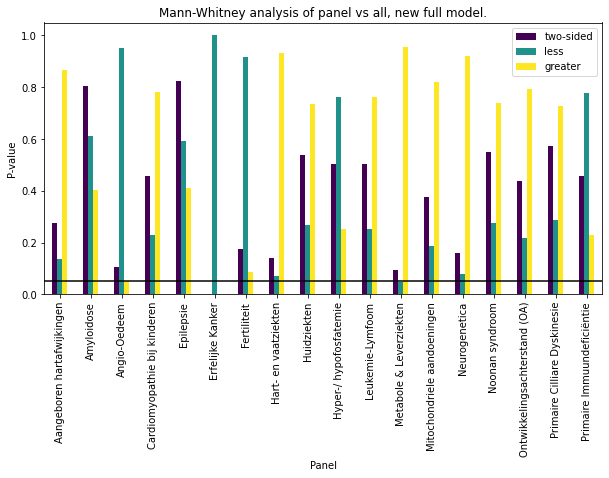

In [80]:
ax = genepanel_auc.plot(y=['two-sided','less','greater'], x='compared_to', kind='bar', colormap='viridis', figsize=(10,5),
                title='Mann-Whitney analysis of panel vs all, new full model.')
ax.hlines(y=0.05,xmin=-10,xmax=100)
ax.set_ylabel('P-value')
ax.set_xlabel('Panel')

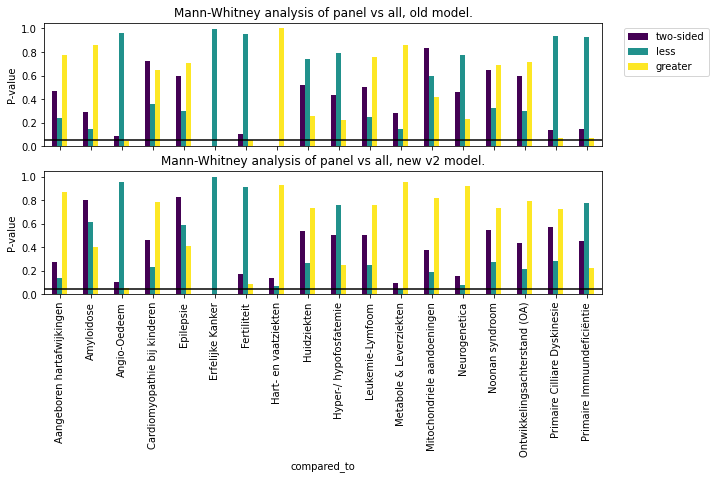

In [78]:
fig, axes = plt.subplots(nrows=2, figsize=(200,100), sharex=True)
previous_model_auc.plot(y=['two-sided','less','greater'], x='compared_to', kind='bar', colormap='viridis', figsize=(10,5),
                title='Mann-Whitney analysis of panel vs all, old model.', ax=axes[0])
axes[0].hlines(y=0.05,xmin=-10,xmax=100)
axes[0].set_ylabel('P-value')
axes[0].set_xlabel('Panel')
axes[0].legend(loc='upper right', bbox_to_anchor=(1.2,1))
genepanel_auc.plot(y=['two-sided','less','greater'], x='compared_to', kind='bar', colormap='viridis', figsize=(10,5),
                title='Mann-Whitney analysis of panel vs all, new v2 model.', ax=axes[1])
axes[1].get_legend().remove()
axes[1].set_ylabel('P-value')
axes[1].hlines(y=0.05,xmin=-10,xmax=100)